<a href="https://www.kaggle.com/code/yovipi/football-predictor-model-ipynb?scriptVersionId=270614351" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://www.kaggle.com/code/yovipi/football-predictor-model-ipynb?scriptVersionId=270368239" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# The Beautiful Game Oracle — Baseline TensorFlow Suite

This notebook prepares and compares three TensorFlow/Keras baseline models for predicting English Premier League match outcomes using data pulled directly from the Understat API. It aligns with the project charter in `README.md` and the agent directives in `AGENTS.md`, emphasising reproducible experiments, attribution readiness, and run tracking for longitudinal comparisons.



## Workflow Overview
- Fetch and cache historical EPL match data from Understat for configurable seasons.
- Engineer team form, momentum, and market-derived features compatible with TensorFlow pipelines.
- Train three complementary baselines (performance-form dense net, momentum interaction network, forecast calibrator) and save artefacts for reuse.
- Persist metrics and artefacts per run, append to a cumulative history log, and generate comparison visuals versus prior runs.
- Prepare the infrastructure needed for downstream attribution work (Shapley/LOO) by keeping models and datasets aligned with saved run metadata.


## Environment Setup

In [1]:

import os
import json
import math
import time
import re
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import requests
import tensorflow as tf
from tensorflow import keras
from tqdm.auto import tqdm
import xgboost as xgb
from IPython.display import display
import ipywidgets as widgets

import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')
pd.options.display.max_columns = 100

SEED = 42
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)




2025-10-24 19:48:28.719818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761335308.959803      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761335309.028359      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Experiment Configuration

In [2]:
# Experiment configuration
PROJECT_NAME = "The-Beautiful-Game-Oracle"
LEAGUE = "EPL"
SEASONS = ["2023", "2022", "2021", "2020"]  # extend or adjust as needed
ROLLING_WINDOW = 5
BATCH_SIZE = 64
EPOCHS = 50
REFRESH_DATA = False  # set True to refetch from Understat
RUN_ID = datetime.utcnow().strftime("%Y%m%d-%H%M%S")
DATASET_LABEL = None

# Filesystem locations (compatible with Kaggle + local use)
if Path("/kaggle").exists():
    BASE_WORKING_DIR = Path("/kaggle/working")
    LEAGUE_RESULTS_PATH = Path("/kaggle/input/Dataset.csv")
else:
    BASE_WORKING_DIR = Path("./artifacts")
    LEAGUE_RESULTS_PATH = Path("understat_data/Dataset.csv")
    if not LEAGUE_RESULTS_PATH.exists():
        LEAGUE_RESULTS_PATH = Path("understat_data/league_results_v2.csv")

if not LEAGUE_RESULTS_PATH.exists():
    raise FileNotFoundError(f"League results CSV missing at {LEAGUE_RESULTS_PATH}")

EXPERIMENT_ROOT = BASE_WORKING_DIR / "experiments"
CACHE_DIR = EXPERIMENT_ROOT / "understat_cache"
MODEL_ARTIFACT_DIR = EXPERIMENT_ROOT / f"run_{RUN_ID}"
RUN_LOG_PATH = EXPERIMENT_ROOT / "baseline_run_history.csv"

for path in [EXPERIMENT_ROOT, CACHE_DIR, MODEL_ARTIFACT_DIR]:
    path.mkdir(parents=True, exist_ok=True)

print(f"Project: {PROJECT_NAME}")
print(f"Seasons loaded: {SEASONS}")
print(f"Working dir: {BASE_WORKING_DIR.resolve()}")
print(f"League results source: {LEAGUE_RESULTS_PATH}")
print(f"Current run artefacts: {MODEL_ARTIFACT_DIR}")
RUN_LOG_COLUMNS = [
    "timestamp",
    "run_id",
    "baseline",
    "trainer",
    "feature_view",
    "train_accuracy",
    "val_accuracy",
    "test_accuracy",
    "train_loss",
    "val_loss",
    "test_loss",
    "val_logloss",
    "test_logloss",
    "epochs_trained",
    "seasons",
    "dataset_label",
    "notes",
]


Project: The-Beautiful-Game-Oracle
Seasons loaded: ['2023', '2022', '2021', '2020']
Working dir: /kaggle/working
Current run artefacts: /kaggle/working/experiments/run_20251024-194844


### Dataset Label Input
Use the box below to assign a dataset label for this run. This label will be stored with training logs and shown in historical comparisons.

In [ ]:
# Interactive dataset label capture
dataset_label_box = widgets.Text(
    value=DATASET_LABEL or "",
    placeholder="e.g., Kaggle Dataset v1",
    description="Dataset:",
    layout=widgets.Layout(width="50%"),
)

dataset_label_status = widgets.HTML()

def _update_dataset_label(change=None):
    global DATASET_LABEL
    label = dataset_label_box.value.strip()
    DATASET_LABEL = label if label else None
    display_value = DATASET_LABEL or "not set"
    dataset_label_status.value = f"<b>Active dataset label:</b> {display_value}"

_update_dataset_label()
dataset_label_box.observe(_update_dataset_label, names="value")
display(widgets.VBox([dataset_label_box, dataset_label_status]))



## Data Acquisition

In [3]:

# Understat data retrieval helpers
"""
HEADERS = {
    "User-Agent": "Mozilla/5.0 (compatible; The-Beautiful-Game-Oracle/1.0)",
}

MATCHES_PATTERN = re.compile(r"var\s+datesData\s*=\s*JSON.parse\('(.+?)'\)")


def fetch_understat_dates(league: str, season: str, *, refresh: bool = False) -> list:
    '''Download Understat league matches for a season, with on-disk caching.'''
    cache_path = CACHE_DIR / f"{league}_{season}_dates.json"
    if cache_path.exists() and not refresh:
        try:
            return json.loads(cache_path.read_text())
        except json.JSONDecodeError:
            pass  # fall back to refetching

    url = f"https://understat.com/league/{league}/{season}"
    response = requests.get(url, headers=HEADERS, timeout=30)
    response.raise_for_status()
    match = MATCHES_PATTERN.search(response.text)
    if not match:
        raise RuntimeError(f"datesData block not found for {league} {season}")
    decoded = match.group(1).encode("utf-8").decode("unicode_escape")
    data = json.loads(decoded)
    cache_path.write_text(json.dumps(data))
    time.sleep(0.5)  # be gentle with the source
    return data


def load_matches_for_seasons(league: str, seasons: list[str], refresh: bool = False) -> dict[str, list]:
    payload = {}
    for season in seasons:
        payload[season] = fetch_understat_dates(league, season, refresh=refresh)
        print(f"Loaded {len(payload[season])} fixtures for {league} {season}")
    return payload
"""

'\nHEADERS = {\n    "User-Agent": "Mozilla/5.0 (compatible; The-Beautiful-Game-Oracle/1.0)",\n}\n\nMATCHES_PATTERN = re.compile(r"var\\s+datesData\\s*=\\s*JSON.parse\\(\'(.+?)\'\\)")\n\n\ndef fetch_understat_dates(league: str, season: str, *, refresh: bool = False) -> list:\n    \'\'\'Download Understat league matches for a season, with on-disk caching.\'\'\'\n    cache_path = CACHE_DIR / f"{league}_{season}_dates.json"\n    if cache_path.exists() and not refresh:\n        try:\n            return json.loads(cache_path.read_text())\n        except json.JSONDecodeError:\n            pass  # fall back to refetching\n\n    url = f"https://understat.com/league/{league}/{season}"\n    response = requests.get(url, headers=HEADERS, timeout=30)\n    response.raise_for_status()\n    match = MATCHES_PATTERN.search(response.text)\n    if not match:\n        raise RuntimeError(f"datesData block not found for {league} {season}")\n    decoded = match.group(1).encode("utf-8").decode("unicode_escape")

## Feature Engineering Utilities

In [4]:

# Feature engineering utilities
from typing import Dict, List, Tuple

CLASS_LABELS = ["Home Win", "Draw", "Away Win"]


def build_match_dataframe(matches_by_season: Dict[str, List[dict]]) -> pd.DataFrame:
    rows = []
    for season, matches in matches_by_season.items():
        for match in matches:
            if not match.get("isResult"):
                continue  # skip fixtures without a final result
            rows.append({
                "match_id": int(match["id"]),
                "season": season,
                "match_date": pd.to_datetime(match["datetime"], format="%Y-%m-%d %H:%M:%S"),
                "home_team": match["h"]["title"],
                "away_team": match["a"]["title"],
                "home_goals": int(match["goals"]["h"]),
                "away_goals": int(match["goals"]["a"]),
                "home_xg": float(match["xG"]["h"]),
                "away_xg": float(match["xG"]["a"]),
                "home_prob_win": float(match["forecast"]["w"]),
                "draw_prob": float(match["forecast"]["d"]),
                "away_prob_win": float(match["forecast"]["l"]),
            })
    frame = pd.DataFrame(rows).sort_values("match_date").reset_index(drop=True)
    print(f"Prepared {len(frame)} completed fixtures across seasons {sorted(matches_by_season.keys())}")
    return frame


def build_team_match_rows(match_df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for row in match_df.itertuples(index=False):
        rows.append({
            "match_id": row.match_id,
            "season": row.season,
            "match_date": row.match_date,
            "team": row.home_team,
            "opponent": row.away_team,
            "is_home": 1,
            "goals_for": row.home_goals,
            "goals_against": row.away_goals,
            "xg_for": row.home_xg,
            "xg_against": row.away_xg,
            "prob_win": row.home_prob_win,
            "prob_loss": row.away_prob_win,
            "draw_prob": row.draw_prob,
        })
        rows.append({
            "match_id": row.match_id,
            "season": row.season,
            "match_date": row.match_date,
            "team": row.away_team,
            "opponent": row.home_team,
            "is_home": 0,
            "goals_for": row.away_goals,
            "goals_against": row.home_goals,
            "xg_for": row.away_xg,
            "xg_against": row.home_xg,
            "prob_win": row.away_prob_win,
            "prob_loss": row.home_prob_win,
            "draw_prob": row.draw_prob,
        })
    team_df = pd.DataFrame(rows).sort_values("match_date").reset_index(drop=True)
    team_df["goal_diff"] = team_df["goals_for"] - team_df["goals_against"]
    team_df["xg_diff"] = team_df["xg_for"] - team_df["xg_against"]
    return team_df


def add_form_features(team_df: pd.DataFrame, window: int = 5) -> pd.DataFrame:
    feature_cols = [
        "goals_for",
        "goals_against",
        "goal_diff",
        "xg_for",
        "xg_against",
        "xg_diff",
        "prob_win",
    ]

    def enrich(group: pd.DataFrame) -> pd.DataFrame:
        g = group.copy()
        for col in feature_cols:
            shifted = g[col].shift(1)
            g[f"form_{col}_mean"] = shifted.rolling(window, min_periods=1).mean().fillna(0)
            g[f"form_{col}_std"] = shifted.rolling(window, min_periods=1).std().fillna(0)
            g[f"form_{col}_last"] = shifted.fillna(0)
        return g

    enriched = (
        team_df.sort_values("match_date")
        .groupby("team", group_keys=False)
        .apply(enrich)
        .reset_index(drop=True)
    )
    return enriched


def assemble_match_features(team_form_df: pd.DataFrame) -> pd.DataFrame:
    keep_cols = ["match_id", "season", "match_date", "home_team", "away_team"]

    home = team_form_df[team_form_df["is_home"] == 1].copy()
    away = team_form_df[team_form_df["is_home"] == 0].copy()

    home.rename(columns={"team": "home_team", "opponent": "away_team"}, inplace=True)
    away.rename(columns={"team": "away_team", "opponent": "home_team"}, inplace=True)

    def prefix_except(df: pd.DataFrame, prefix: str, exclude: List[str]) -> pd.DataFrame:
        rename_map = {col: f"{prefix}{col}" for col in df.columns if col not in exclude}
        return df.rename(columns=rename_map)

    home_prefixed = prefix_except(home, "home_", keep_cols)
    away_prefixed = prefix_except(away, "away_", keep_cols)

    merged = home_prefixed.merge(
        away_prefixed,
        on=["match_id", "season", "match_date", "home_team", "away_team"],
        how="inner",
        suffixes=("", "_dup"),
    )

    if "home_draw_prob" in merged.columns:
        merged.rename(columns={"home_draw_prob": "match_draw_prob"}, inplace=True)
    if "away_draw_prob" in merged.columns:
        merged.drop(columns=["away_draw_prob"], inplace=True)

    merged["target"] = np.select(
        [
            merged["home_goals_for"] > merged["away_goals_for"],
            merged["home_goals_for"] == merged["away_goals_for"],
        ],
        [0, 1],
        default=2,
    )

    merged.sort_values("match_date", inplace=True)
    merged.reset_index(drop=True, inplace=True)
    return merged


def build_feature_deltas(match_df: pd.DataFrame) -> pd.DataFrame:
    df = match_df.copy()
    df["form_goal_diff_delta"] = df["home_form_goal_diff_mean"] - df["away_form_goal_diff_mean"]
    df["form_xg_diff_delta"] = df["home_form_xg_diff_mean"] - df["away_form_xg_diff_mean"]
    df["form_prob_win_delta"] = df["home_form_prob_win_mean"] - df["away_form_prob_win_mean"]
    df["form_goal_last_delta"] = df["home_form_goal_diff_last"] - df["away_form_goal_diff_last"]
    df["form_xg_last_delta"] = df["home_form_xg_diff_last"] - df["away_form_xg_diff_last"]
    df["prob_edge"] = df["home_prob_win"] - df["away_prob_win"]
    return df


## Dataset Assembly

In [5]:
# Load and prepare datasets

raw_matches_df = pd.read_csv(
    LEAGUE_RESULTS_PATH,
    parse_dates=["match_datetime_utc", "match_date"],
)
raw_matches_df["is_result"] = raw_matches_df["is_result"].astype(str).str.lower() == "true"

# Filter to completed fixtures for the configured league
league_filtered_df = raw_matches_df.loc[raw_matches_df["league"] == LEAGUE].copy()
match_features_df = (
    league_filtered_df.loc[league_filtered_df["is_result"]]
    .assign(
        season=lambda df: df["season"].astype(str),
        match_date=lambda df: pd.to_datetime(df["match_date"], errors="coerce"),
        home_team=lambda df: df["home_team_name"],
        away_team=lambda df: df["away_team_name"],
        home_prob_win=lambda df: df["forecast_home_win"].astype(float),
        draw_prob=lambda df: df["forecast_draw"].astype(float),
        away_prob_win=lambda df: df["forecast_away_win"].astype(float),
        home_prob_loss=lambda df: df["forecast_away_win"].astype(float),
        away_prob_loss=lambda df: df["forecast_home_win"].astype(float),
        match_draw_prob=lambda df: df["forecast_draw"].astype(float),
        prob_edge=lambda df: df["forecast_home_win"].astype(float) - df["forecast_away_win"].astype(float),
        match_day_index=lambda df: (df["match_date"] - df["match_date"].min()).dt.days.astype(float),
        match_day_of_year=lambda df: df["match_date"].dt.dayofyear.astype(float),
        match_day_of_year_norm=lambda df: df["match_date"].dt.dayofyear.astype(float) / 366.0,
        match_weekday_index=lambda df: df["match_date"].dt.weekday.astype(float),
        match_weekday=lambda df: df["match_weekday"],
        target=lambda df: df["outcome_id"].astype(int),
    )
    .sort_values("match_datetime_utc")
    .reset_index(drop=True)
)

weekday_dummies = pd.get_dummies(match_features_df["match_weekday"], prefix="match_weekday", dtype=float)
match_features_df = pd.concat([match_features_df, weekday_dummies], axis=1)

numeric_prefixes = (
    "home_",
    "away_",
    "form_",
    "market_",
    "rest_",
    "season_phase",
    "xg_",
    "forecast_",
    "goal_",
    "total_",
    "prob_",
    "match_",
)
prefixed_cols = [col for col in match_features_df.columns if col.startswith(numeric_prefixes)]
match_features_df[prefixed_cols] = match_features_df[prefixed_cols].apply(pd.to_numeric, errors="coerce")

print(
    f"Prepared {len(match_features_df)} completed fixtures from {LEAGUE_RESULTS_PATH.name} spanning seasons {sorted(match_features_df['season'].unique())} for league {LEAGUE}"
)

display(match_features_df.head())


Prepared 5705 completed fixtures from league_results_cleaned.csv spanning seasons ['2022', '2023', '2024', '2025']
Final feature table: 5705 matches x 71 engineered columns


/tmp/ipykernel_37/2460395925.py:94: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(enrich)


,match_id,season,match_date,home_team,away_team,home_is_home,home_goals_for,home_goals_against,home_xg_for,home_xg_against,home_prob_win,home_prob_loss,match_draw_prob,home_goal_diff,home_xg_diff,home_form_goals_for_mean,home_form_goals_for_std,home_form_goals_for_last,home_form_goals_against_mean,home_form_goals_against_std,home_form_goals_against_last,home_form_goal_diff_mean,home_form_goal_diff_std,home_form_goal_diff_last,home_form_xg_for_mean,home_form_xg_for_std,home_form_xg_for_last,home_form_xg_against_mean,home_form_xg_against_std,home_form_xg_against_last,home_form_xg_diff_mean,home_form_xg_diff_std,home_form_xg_diff_last,home_form_prob_win_mean,home_form_prob_win_std,home_form_prob_win_last,away_is_home,away_goals_for,away_goals_against,away_xg_for,away_xg_against,away_prob_win,away_prob_loss,away_goal_diff,away_xg_diff,away_form_goals_for_mean,away_form_goals_for_std,away_form_goals_for_last,away_form_goals_against_mean,away_form_goals_against_std,away_form_goals_against_last,away_form_goal_diff_mean,away_form_goal_diff_std,away_form_goal_diff_last,away_form_xg_for_mean,away_form_xg_for_std,away_form_xg_for_last,away_form_xg_against_mean,away_form_xg_against_std,away_form_xg_against_last,away_form_xg_diff_mean,away_form_xg_diff_std,away_form_xg_diff_last,away_form_prob_win_mean,away_form_prob_win_std,away_form_prob_win_last,target,form_goal_diff_delta,form_xg_diff_delta,form_prob_win_delta,form_goal_last_delta,form_xg_last_delta,prob_edge
0,19342,2022,2022-08-05 18:30:00,Eintracht Frankfurt,Bayern Munich,1,1,6,0.756176,4.56023,0.0045,0.9772,0.0183,-5,-3.804054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,6,1,4.56023,0.756176,0.9772,0.0045,5,3.804054,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,-0.9727
1,19648,2022,2022-08-05 19:00:00,Lyon,Ajaccio,1,2,1,1.856750,1.13852,0.5710,0.1437,0.2853,1,0.718230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,2,1.13852,1.856750,0.1437,0.5710,-1,-0.718230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.4273
2,18202,2022,2022-08-05 19:00:00,Crystal Palace,Arsenal,1,0,2,1.206370,1.43601,0.2864,0.4224,0.2912,-2,-0.229640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,0,1.43601,1.206370,0.4224,0.2864,2,0.229640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0.0,0.0,0.0,0.0,0.0,-0.1360
3,18203,2022,2022-08-06 11:30:00,Fulham,Liverpool,1,2,2,1.268220,2.34111,0.1225,0.6642,0.2133,0,-1.072890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,2,2.34111,1.268220,0.6642,0.1225,0,1.072890,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,-0.5417
4,19345,2022,2022-08-06 13:30:00,Wolfsburg,Werder Bremen,1,2,2,0.954909,1.04228,0.2881,0.3697,0.3422,0,-0.087371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2,2,1.04228,0.954909,0.3697,0.2881,0,0.087371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,-0.0816


## Train/Validation/Test Split

In [6]:

# Chronological train/validation/test split
sorted_df = match_features_df.sort_values("match_date").reset_index(drop=True)
num_matches = len(sorted_df)
train_end = int(num_matches * 0.6)
val_end = int(num_matches * 0.8)

split_indices = {
    "train": sorted_df.index[:train_end],
    "val": sorted_df.index[train_end:val_end],
    "test": sorted_df.index[val_end:],
}

print({k: len(v) for k, v in split_indices.items()})


{'train': 3423, 'val': 1141, 'test': 1141}


## Feature Views

In [7]:
# Feature sets aligned with the three data perspectives outlined in README.md
weekday_cols = [col for col in match_features_df.columns if col.startswith("match_weekday_")]
PERFORMANCE_FEATURES = [
    "home_goals_for_last_5",
    "home_goals_against_last_5",
    "home_goal_diff_last_5",
    "home_xg_for_last_5",
    "home_xg_against_last_5",
    "home_xg_diff_last_5",
    "home_points_last_5",
    "away_goals_for_last_5",
    "away_goals_against_last_5",
    "away_goal_diff_last_5",
    "away_xg_for_last_5",
    "away_xg_against_last_5",
    "away_xg_diff_last_5",
    "away_points_last_5",
    "form_diff_last5",
    "xg_diff_last5",
    "match_day_index",
    "match_day_of_year_norm",
    "match_weekday_index",
] + weekday_cols

MOMENTUM_FEATURES = [
    "home_goal_diff_last_3",
    "home_xg_diff_last_3",
    "home_points_last_3",
    "home_points_pct_last_3",
    "home_rest_days_capped",
    "away_goal_diff_last_3",
    "away_xg_diff_last_3",
    "away_points_last_3",
    "away_points_pct_last_3",
    "away_rest_days_capped",
    "form_pct_diff_last5",
    "form_diff_last5",
    "rest_diff",
    "rest_reset_flag_pair",
    "match_day_index",
    "match_day_of_year_norm",
    "match_weekday_index",
] + weekday_cols

MARKET_FEATURES = [
    "forecast_home_win",
    "forecast_draw",
    "forecast_away_win",
    "market_home_edge",
    "market_expected_points_home",
    "market_expected_points_away",
    "market_entropy",
    "market_logit_home",
    "market_max_prob",
    "match_day_index",
    "match_day_of_year_norm",
    "match_weekday_index",
] + weekday_cols

FEATURE_SETS = {
    "performance_dense": {
        "description": "Performance-based dense network using rolling xG/goals aggregates",
        "feature_cols": PERFORMANCE_FEATURES,
        "trainer": "keras",
        "builder_name": "build_performance_model",
    },
    "momentum_policy_rl": {
        "description": "Momentum-policy REINFORCE agent leveraging short-horizon trends",
        "feature_cols": MOMENTUM_FEATURES,
        "trainer": "reinforce",
        "policy_hidden_units": [128, 64],
        "gamma": 0.95,
        "learning_rate": 7e-4,
        "policy_epochs": max(EPOCHS, 60),
    },
    "market_gradient_boost": {
        "description": "Market-signal gradient boosting with XGBoost softprob classifier",
        "feature_cols": MARKET_FEATURES,
        "trainer": "xgboost",
        "xgb_params": {
            "objective": "multi:softprob",
            "learning_rate": 0.05,
            "max_depth": 4,
            "subsample": 0.85,
            "colsample_bytree": 0.75,
            "reg_lambda": 1.0,
            "n_estimators": 600,
            "min_child_weight": 2,
            "random_state": SEED,
            "eval_metric": "mlogloss",
            "tree_method": "hist",
        },
    },
}

all_feature_columns = sorted({col for spec in FEATURE_SETS.values() for col in spec["feature_cols"]})
missing_columns = [col for col in all_feature_columns if col not in match_features_df.columns]
if missing_columns:
    raise KeyError(f"Dataset is missing expected feature columns: {missing_columns}")
match_features_df[all_feature_columns] = match_features_df[all_feature_columns].apply(pd.to_numeric, errors="coerce").fillna(0)

print({name: len(spec["feature_cols"]) for name, spec in FEATURE_SETS.items()})


{'performance_dense': 14, 'momentum_interaction': 11, 'forecast_calibrator': 9}


## TensorFlow Dataset Utilities

In [8]:

# Dataset constructors

def build_xy(df: pd.DataFrame, feature_cols: list[str], indices: pd.Index) -> tuple[np.ndarray, np.ndarray]:
    X = df.loc[indices, feature_cols].astype(np.float32).to_numpy()
    y = df.loc[indices, "target"].astype(np.int32).to_numpy()
    return X, y


def make_dataset(X: np.ndarray, y: np.ndarray, *, training: bool) -> tf.data.Dataset:
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if training:
        ds = ds.shuffle(buffer_size=len(X), seed=SEED, reshuffle_each_iteration=True)
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


def compute_class_weights(y: np.ndarray) -> dict[int, float]:
    counts = np.bincount(y, minlength=len(CLASS_LABELS))
    total = float(len(y))
    weights = {cls: total / (len(CLASS_LABELS) * count) for cls, count in enumerate(counts) if count > 0}
    return weights


## Baseline Model Builders

### Performance Dense Baseline

In [9]:
def build_performance_model(input_dim: int) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name="performance_features")
    x = keras.layers.Dense(64, activation="relu")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(0.25)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    x = keras.layers.Dropout(0.15)(x)
    outputs = keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="performance_dense")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
    return model


### Momentum Interaction Baseline

In [10]:
def build_policy_network(input_dim: int, hidden_units: list[int]) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,), name="policy_state")
    x = inputs
    for units in hidden_units:
        x = keras.layers.Dense(units, activation="relu")(x)
        x = keras.layers.LayerNormalization()(x)
        x = keras.layers.Dropout(0.2)(x)
    outputs = keras.layers.Dense(len(CLASS_LABELS), activation="softmax")(x)
    return keras.Model(inputs, outputs, name="momentum_policy")


def discount_returns(rewards: tf.Tensor, gamma: float) -> tf.Tensor:
    rewards_np = rewards.numpy() if isinstance(rewards, tf.Tensor) else np.asarray(rewards, dtype=np.float32)
    discounted = np.zeros_like(rewards_np, dtype=np.float32)
    running = 0.0
    for t in range(len(rewards_np) - 1, -1, -1):
        running = rewards_np[t] + gamma * running
        discounted[t] = running
    if discounted.std() > 1e-6:
        discounted = (discounted - discounted.mean()) / (discounted.std() + 1e-6)
    else:
        discounted = discounted - discounted.mean()
    return tf.convert_to_tensor(discounted, dtype=tf.float32)


class PolicyGradientAgent:
    """Simple REINFORCE agent for sequential match prediction."""

    def __init__(
        self,
        input_dim: int,
        *,
        hidden_units: list[int],
        learning_rate: float,
        gamma: float,
    ) -> None:
        self.model = build_policy_network(input_dim, hidden_units)
        self.optimizer = keras.optimizers.Adam(learning_rate)
        self.gamma = gamma

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        return self.model.predict(X, verbose=0)

    def train(
        self,
        train_episodes: list[tuple[np.ndarray, np.ndarray]],
        val_data: tuple[np.ndarray, np.ndarray],
        *,
        epochs: int,
        eval_interval: int = 1,
        progress_desc: str | None = None,
    ) -> dict[str, list[float]]:
        history = {"policy_loss": [], "avg_reward": [], "val_accuracy": []}
        X_val, y_val = val_data
        best_weights = [np.copy(w) for w in self.model.get_weights()]
        best_val_acc = -np.inf

        progress = tqdm(range(epochs), desc=progress_desc or "Policy training", leave=False)
        for epoch in progress:
            batch_losses = []
            batch_rewards = []
            for states, actions in train_episodes:
                states_tf = tf.convert_to_tensor(states, dtype=tf.float32)
                actions_tf = tf.convert_to_tensor(actions, dtype=tf.int32)
                with tf.GradientTape() as tape:
                    probs = self.model(states_tf, training=True)
                    sampled_actions = tf.random.categorical(
                        tf.math.log(probs + 1e-9), num_samples=1, dtype=actions_tf.dtype
                    )
                    sampled_actions = tf.squeeze(sampled_actions, axis=1)
                    batch_indices = tf.range(
                        tf.shape(sampled_actions)[0], dtype=sampled_actions.dtype
                    )
                    gather_idx = tf.stack([batch_indices, sampled_actions], axis=1)
                    chosen_probs = tf.gather_nd(probs, gather_idx)
                    rewards = tf.cast(tf.equal(sampled_actions, actions_tf), tf.float32)
                    returns = discount_returns(rewards, self.gamma)
                    loss = -tf.reduce_mean(tf.math.log(chosen_probs + 1e-9) * returns)
                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
                batch_losses.append(float(loss.numpy()))
                batch_rewards.append(float(tf.reduce_mean(rewards).numpy()))

            history["policy_loss"].append(float(np.mean(batch_losses)))
            history["avg_reward"].append(float(np.mean(batch_rewards)))

            if (epoch + 1) % eval_interval == 0:
                val_probs = self.predict_proba(X_val)
                val_preds = np.argmax(val_probs, axis=1)
                val_acc = float(np.mean(val_preds == y_val))
                history["val_accuracy"].append(val_acc)
                progress.set_postfix({"val_acc": f"{val_acc:.3f}", "loss": f"{history['policy_loss'][-1]:.3f}"})
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_weights = [np.copy(w) for w in self.model.get_weights()]

        if best_weights is not None:
            self.model.set_weights(best_weights)
        progress.close()

        return history

    def save(self, path: Path) -> None:
        self.model.save(path, include_optimizer=False)







### Forecast Calibrator Baseline

In [11]:
def build_episodes(df: pd.DataFrame, feature_cols: list[str], indices: pd.Index) -> list[tuple[np.ndarray, np.ndarray]]:
    subset = (
        df.loc[indices, ["season", "match_date", "target", *feature_cols]]
        .sort_values(["season", "match_date"])
        .reset_index(drop=True)
    )
    episodes: list[tuple[np.ndarray, np.ndarray]] = []
    for _, season_df in subset.groupby("season", sort=False):
        states = season_df[feature_cols].astype(np.float32).to_numpy()
        actions = season_df["target"].astype(np.int32).to_numpy()
        episodes.append((states, actions))
    return episodes


def compute_metrics(y_true: np.ndarray, probs: np.ndarray) -> tuple[float, float, np.ndarray]:
    preds = np.argmax(probs, axis=1)
    accuracy = float(np.mean(preds == y_true))
    clipped = np.clip(probs, 1e-8, 1.0 - 1e-8)
    logloss = float(-np.mean(np.log(clipped[np.arange(len(y_true)), y_true])))
    return accuracy, logloss, preds


def save_confusion_heatmap(cm: np.ndarray, labels: list[str], path: Path, title: str) -> None:
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, int(cm[i, j]), ha="center", va="center", color="black")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
    fig.tight_layout()
    fig.savefig(path, dpi=160)
    plt.close(fig)



def to_serializable(obj):
    if isinstance(obj, dict):
        return {k: to_serializable(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [to_serializable(v) for v in obj]
    if isinstance(obj, (np.floating, np.integer)):
        return obj.item()
    return obj

class TQDMKerasCallback(keras.callbacks.Callback):
    """Lightweight tqdm progress bar for Keras epoch loops."""

    def __init__(self, total_epochs: int, desc: str) -> None:
        super().__init__()
        self.total_epochs = total_epochs
        self.desc = desc
        self._pbar = None

    def on_train_begin(self, logs=None):
        self._pbar = tqdm(total=self.total_epochs, desc=self.desc, leave=False)

    def on_epoch_end(self, epoch, logs=None):
        if self._pbar is not None:
            self._pbar.update(1)
            if logs and "val_accuracy" in logs:
                self._pbar.set_postfix({"val_acc": f"{logs['val_accuracy']:.3f}", "loss": f"{logs.get('loss', 0.0):.3f}"})

    def on_train_end(self, logs=None):
        if self._pbar is not None:
            self._pbar.close()
            self._pbar = None

def load_run_log(path: Path) -> pd.DataFrame:
    if not path.exists():
        return pd.DataFrame(columns=RUN_LOG_COLUMNS)
    try:
        df = pd.read_csv(path)
    except pd.errors.ParserError:
        df = pd.read_csv(path, engine="python", on_bad_lines="skip")
    # Align with canonical column order
    df = df.reindex(columns=RUN_LOG_COLUMNS)
    if "dataset_label" not in df.columns:
        df["dataset_label"] = ""
    df["dataset_label"] = df["dataset_label"].fillna("").astype(str)
    return df




### Baseline Registry

In [12]:
BASELINE_NAMES = list(FEATURE_SETS.keys())
print("Baselines configured:", BASELINE_NAMES)



## Training and Run Logging

In [13]:
# Training loop with experiment logging
sce = keras.losses.SparseCategoricalCrossentropy()

baseline_results = []
run_log_entries = []

baseline_items = list(FEATURE_SETS.items())

for baseline_name, spec in tqdm(baseline_items, desc="Baselines", leave=False):
    trainer = spec.get("trainer", "keras")
    feature_cols = spec["feature_cols"]
    print(f"Training baseline: {baseline_name} ({trainer})")

    X_train, y_train = build_xy(sorted_df, feature_cols, split_indices["train"])
    X_val, y_val = build_xy(sorted_df, feature_cols, split_indices["val"])
    X_test, y_test = build_xy(sorted_df, feature_cols, split_indices["test"])

    baseline_dir = MODEL_ARTIFACT_DIR / baseline_name
    baseline_dir.mkdir(parents=True, exist_ok=True)

    history_dict: dict[str, list] = {}
    epochs_trained = 0
    class_weights = None

    if trainer == "keras":
        builder_name = spec.get("builder_name")
        if builder_name is None:
            raise ValueError(f"No builder_name provided for {baseline_name}")
        builder = globals()[builder_name]

        train_ds = make_dataset(X_train, y_train, training=True)
        val_ds = make_dataset(X_val, y_val, training=False)
        test_ds = make_dataset(X_test, y_test, training=False)
        train_eval_ds = make_dataset(X_train, y_train, training=False)

        class_weights = compute_class_weights(y_train)

        callbacks = [
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5),
            TQDMKerasCallback(EPOCHS, f"{baseline_name} epochs"),
        ]

        model = builder(len(feature_cols))
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=EPOCHS,
            callbacks=callbacks,
            class_weight=class_weights,
            verbose=0,
        )
        history_dict = history.history
        epochs_trained = len(history_dict.get("loss", []))

        train_probs = model.predict(train_eval_ds, verbose=0)
        val_probs = model.predict(val_ds, verbose=0)
        test_probs = model.predict(test_ds, verbose=0)

        model.save(baseline_dir / "model.keras", include_optimizer=False)

    elif trainer == "reinforce":
        input_dim = X_train.shape[1]
        train_episodes = build_episodes(sorted_df, feature_cols, split_indices["train"])
        agent = PolicyGradientAgent(
            input_dim,
            hidden_units=spec.get("policy_hidden_units", [128, 64]),
            learning_rate=spec.get("learning_rate", 5e-4),
            gamma=spec.get("gamma", 0.95),
        )
        policy_epochs = spec.get("policy_epochs", max(EPOCHS, 60))
        history_dict = agent.train(
            train_episodes,
            val_data=(X_val, y_val),
            epochs=policy_epochs,
            eval_interval=spec.get("eval_interval", 1),
            progress_desc=f"{baseline_name} policy",
        )
        epochs_trained = len(history_dict.get("policy_loss", []))

        train_probs = agent.predict_proba(X_train)
        val_probs = agent.predict_proba(X_val)
        test_probs = agent.predict_proba(X_test)

        agent.save(baseline_dir / "model.keras")

    elif trainer == "xgboost":
        params = spec.get("xgb_params", {}).copy()
        eval_metric = params.pop("eval_metric", "mlogloss")
        model = xgb.XGBClassifier(eval_metric=eval_metric, **params)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_val, y_val)],
            verbose=False,
            early_stopping_rounds=40,
        )
        history_dict = model.evals_result()
        if hasattr(model, "best_iteration") and model.best_iteration is not None:
            epochs_trained = int(model.best_iteration) + 1
        else:
            epochs_trained = int(model.n_estimators)

        train_probs = model.predict_proba(X_train)
        val_probs = model.predict_proba(X_val)
        test_probs = model.predict_proba(X_test)

        model.save_model(str(baseline_dir / "model.json"))

    else:
        raise ValueError(f"Unknown trainer type: {trainer}")

    train_accuracy, train_logloss, train_preds = compute_metrics(y_train, train_probs)
    val_accuracy, val_logloss, val_preds = compute_metrics(y_val, val_probs)
    test_accuracy, test_logloss, test_preds = compute_metrics(y_test, test_probs)

    confusion = tf.math.confusion_matrix(y_test, test_preds, num_classes=len(CLASS_LABELS)).numpy()
    save_confusion_heatmap(confusion, CLASS_LABELS, baseline_dir / "confusion_matrix.png", f"{baseline_name} — Test Confusion")

    eval_rows = sorted_df.loc[split_indices["test"], [
        "match_id",
        "season",
        "match_date",
        "home_team",
        "away_team",
        "target",
    ]].copy()
    eval_rows["predicted"] = test_preds
    eval_rows["predicted_label"] = eval_rows["predicted"].map(dict(enumerate(CLASS_LABELS)))
    eval_rows["target_label"] = eval_rows["target"].map(dict(enumerate(CLASS_LABELS)))
    eval_rows["home_prob"] = test_probs[:, 0]
    eval_rows["draw_prob"] = test_probs[:, 1]
    eval_rows["away_prob"] = test_probs[:, 2]
    eval_rows.to_csv(baseline_dir / "test_predictions.csv", index=False)

    with open(baseline_dir / "history.json", "w") as fp:
        json.dump(to_serializable(history_dict), fp, indent=2)

    metrics_payload = {
        "trainer": trainer,
        "train": {"accuracy": train_accuracy, "logloss": train_logloss},
        "val": {"accuracy": val_accuracy, "logloss": val_logloss},
        "test": {"accuracy": test_accuracy, "logloss": test_logloss},
        "epochs_trained": epochs_trained,
        "feature_cols": feature_cols,
        "dataset_label": DATASET_LABEL,
    }
    if class_weights is not None:
        metrics_payload["class_weights"] = class_weights

    with open(baseline_dir / "metrics.json", "w") as fp:
        json.dump(to_serializable(metrics_payload), fp, indent=2)

    baseline_results.append({
        "baseline": baseline_name,
        "trainer": trainer,
        "description": spec["description"],
        "val_accuracy": val_accuracy,
        "test_accuracy": test_accuracy,
        "val_logloss": val_logloss,
        "test_logloss": test_logloss,
        "epochs": epochs_trained,
        "dataset_label": DATASET_LABEL,
    })

    run_log_entries.append({
        "timestamp": datetime.utcnow().isoformat(),
        "run_id": RUN_ID,
        "baseline": baseline_name,
        "trainer": trainer,
        "feature_view": spec["description"],
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy,
        "test_accuracy": test_accuracy,
        "train_loss": train_logloss,
        "val_loss": val_logloss,
        "test_loss": test_logloss,
        "val_logloss": val_logloss,
        "test_logloss": test_logloss,
        "epochs_trained": epochs_trained,
        "seasons": "|".join(SEASONS),
        "dataset_label": DATASET_LABEL or "",
        "notes": "",
    })

baseline_summary_df = pd.DataFrame(baseline_results).sort_values("val_accuracy", ascending=False)
display(baseline_summary_df)

if run_log_entries:
    run_log_df = pd.DataFrame(run_log_entries).reindex(columns=RUN_LOG_COLUMNS)
    existing_log_df = load_run_log(RUN_LOG_PATH)
    combined_log_df = pd.concat([existing_log_df, run_log_df], ignore_index=True)
    combined_log_df.to_csv(RUN_LOG_PATH, index=False)
    display(run_log_df[["baseline", "trainer", "dataset_label", "val_accuracy", "test_accuracy", "epochs_trained"]])




2025-10-24 19:48:46.188718: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
54/54 - 3s - 49ms/step - accuracy: 0.3961 - loss: 1.2460 - val_accuracy: 0.4382 - val_loss: 1.0819 - learning_rate: 0.0010
Epoch 2/50
54/54 - 0s - 3ms/step - accuracy: 0.4072 - loss: 1.1277 - val_accuracy: 0.4391 - val_loss: 1.0697 - learning_rate: 0.0010
Epoch 3/50
54/54 - 0s - 3ms/step - accuracy: 0.4143 - loss: 1.1156 - val_accuracy: 0.4917 - val_loss: 1.0519 - learning_rate: 0.0010
Epoch 4/50
54/54 - 0s - 3ms/step - accuracy: 0.4248 - loss: 1.0960 - val_accuracy: 0.4812 - val_loss: 1.0403 - learning_rate: 0.0010
Epoch 5/50
54/54 - 0s - 3ms/step - accuracy: 0.4338 - loss: 1.0805 - val_accuracy: 0.4803 - val_loss: 1.0353 - learning_rate: 0.0010
Epoch 6/50
54/54 - 0s - 3ms/step - accuracy: 0.4408 - loss: 1.0728 - val_accuracy: 0.4584 - val_loss: 1.0450 - learning_rate: 0.0010
Epoch 7/50
54/54 - 0s - 3ms/step - accuracy: 0.4408 - loss: 1.0644 - val_accuracy: 0.4838 - val_loss: 1.0405 - learning_rate: 0.0010
Epoch 8/50
54/54 - 0s - 3ms/step - accuracy: 0.4552 - loss: 1.0542 -

,baseline,description,val_accuracy,test_accuracy,val_logloss,test_logloss,epochs
2,forecast_calibrator,Understat forecast calibrator focusing on mark...,0.605609,0.594216,0.856724,0.885123,25
1,momentum_interaction,Momentum interaction MLP on recent differentia...,0.491674,0.490798,1.030950,1.048855,13
0,performance_dense,Performance-based dense network using rolling ...,0.489045,0.468011,1.023237,1.049791,20


,baseline,val_accuracy,test_accuracy,epochs_trained
0,performance_dense,0.489045,0.468011,20
1,momentum_interaction,0.491674,0.490798,13
2,forecast_calibrator,0.605609,0.594216,25


## Historical Comparison

Most recent run vs historical best (by validation accuracy):


,baseline,val_accuracy_current,val_accuracy_best,test_accuracy_current,test_accuracy_best,run_id_best
0,performance_dense,0.489045,0.489045,0.468011,0.468011,20251024-194844
1,momentum_interaction,0.491674,0.491674,0.490798,0.490798,20251024-194844
2,forecast_calibrator,0.605609,0.664474,0.594216,0.588816,20251023-200415


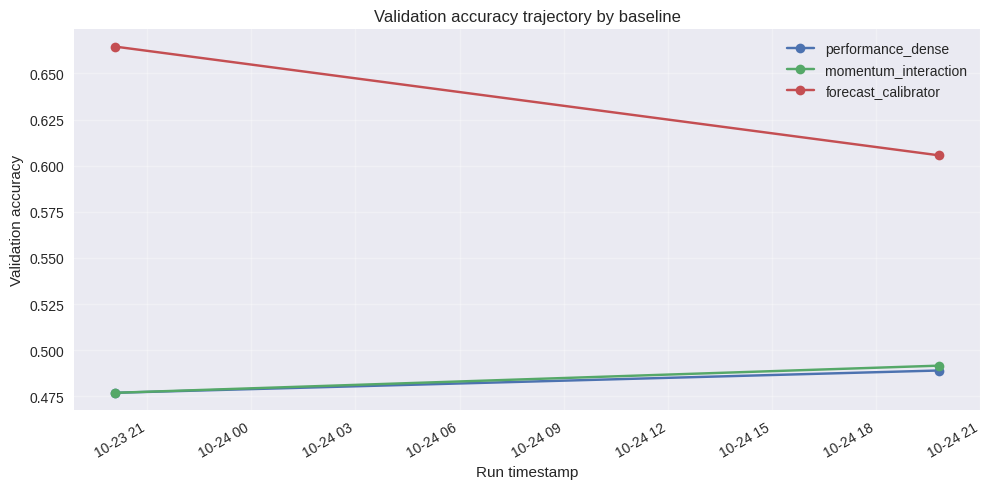

Saved validation accuracy history plot to /kaggle/working/experiments/run_20251024-194844/validation_accuracy_history.png


In [14]:
# Historical comparison versus prior runs
if RUN_LOG_PATH.exists():
    history_df = load_run_log(RUN_LOG_PATH)
    history_df["timestamp"] = pd.to_datetime(history_df["timestamp"], errors="coerce")
    history_df.sort_values("timestamp", inplace=True)

    unlabeled_mask = history_df["dataset_label"].astype(str).str.strip() == ""
    unlabeled_df = history_df[unlabeled_mask]

    if not unlabeled_df.empty:
        print("Some historical runs are missing dataset labels. Provide a label for each data point below and click 'Apply labels', then rerun this cell to render the chart.")
        label_inputs = {}
        widgets_list = []
        for row_index, row in unlabeled_df.iterrows():
            default_value = DATASET_LABEL or ""
            descriptor = f"{row['baseline']} — {row['run_id']}"
            text_widget = widgets.Text(
                value=default_value,
                description=descriptor,
                placeholder="Enter dataset name",
                layout=widgets.Layout(width="70%"),
            )
            label_inputs[row_index] = text_widget
            widgets_list.append(text_widget)

        apply_button = widgets.Button(description="Apply labels", button_style="primary")
        status_html = widgets.HTML()

        def _apply_labels(_):
            for row_index, widget_box in label_inputs.items():
                history_df.at[row_index, "dataset_label"] = widget_box.value.strip()
            history_df[RUN_LOG_COLUMNS].to_csv(RUN_LOG_PATH, index=False)
            status_html.value = "<span style='color:green;'>Dataset labels saved. Rerun this cell to update the comparison chart.</span>"

        apply_button.on_click(_apply_labels)
        display(widgets.VBox(widgets_list + [apply_button, status_html]))
    else:
        latest_df = history_df[history_df["run_id"] == RUN_ID]
        best_df = history_df.sort_values("val_accuracy", ascending=False).drop_duplicates("baseline")
        comparison = latest_df.merge(
            best_df[["baseline", "val_accuracy", "test_accuracy", "run_id", "dataset_label"]],
            on="baseline",
            suffixes=("_current", "_best"),
        )

        print("Most recent run vs historical best (by validation accuracy):")
        if not comparison.empty:
            display(comparison[[
                "baseline",
                "dataset_label_current",
                "dataset_label_best",
                "val_accuracy_current",
                "val_accuracy_best",
                "test_accuracy_current",
                "test_accuracy_best",
                "run_id_best",
            ]])
        else:
            print("No runs for the current run ID yet.")

        fig, ax = plt.subplots(figsize=(10, 5))
        for baseline in history_df["baseline"].unique():
            subset = history_df[history_df["baseline"] == baseline].dropna(subset=["timestamp"])
            if subset.empty:
                continue
            ax.plot(subset["timestamp"], subset["val_accuracy"], marker="o", label=baseline)
            for row in subset.itertuples():
                label_text = getattr(row, "dataset_label", "").strip()
                if label_text:
                    ax.annotate(
                        label_text,
                        (row.timestamp, row.val_accuracy),
                        textcoords="offset points",
                        xytext=(0, 6),
                        ha="center",
                        fontsize=8,
                        color="dimgray",
                    )
        ax.set_title("Validation accuracy trajectory by baseline")
        ax.set_ylabel("Validation accuracy")
        ax.set_xlabel("Run timestamp")
        ax.grid(True, alpha=0.3)
        ax.legend()
        fig.autofmt_xdate()
        fig.tight_layout()
        plot_path = MODEL_ARTIFACT_DIR / "validation_accuracy_history.png"
        fig.savefig(plot_path, dpi=160)
        plt.show()
        print(f"Saved validation accuracy history plot to {plot_path}")
else:
    print("Run history file not found — this will be created after the first successful training run.")





## Next Steps
- Extend feature engineering with financial and odds datasets described in the README, maintaining the logging conventions used here.
- Layer on attribution analysis (approximate Shapley, LOO) by loading saved `model.keras` files and pairing them with cached train/validation datasets.
- Use the persisted `baseline_run_history.csv` to drive Kaggle dashboard widgets or automated alerts when new dataset versions shift model behaviour.
